In [114]:
import numpy as np
import matplotlib as mplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [115]:
# INPUT samplefiles
sample_set1 = np.loadtxt("sample_data/output1")
sample_set1.shape
print sample_set1

sample_set2 = np.loadtxt("sample_data/output2")
sample_set2.shape
print sample_set2

sample_set3 = np.loadtxt("sample_data/output3")
sample_set3.shape
print sample_set3

# labels
labels = np.array([0]*10000 + [1]*10000)

# case 1
case1_sample_set = np.vstack((sample_set1,sample_set2))

# case 2
case2_sample_set = np.vstack((sample_set1,sample_set3))

[[-1.12555   2.30073 ]
 [ 0.893382  2.05753 ]
 [ 0.396082 -0.346045]
 ..., 
 [ 1.49938   2.42217 ]
 [ 0.291466  0.451006]
 [ 0.283505  1.37081 ]]
[[ 5.67545  4.99639]
 [ 3.52939  4.22108]
 [ 6.03152  4.55437]
 ..., 
 [ 4.09174  5.63306]
 [ 6.81109  5.93923]
 [ 8.52825  5.88855]]
[[  1.7725   14.4119 ]
 [  9.31248   6.21824]
 [  5.53525  10.483  ]
 ..., 
 [  9.0647    2.34176]
 [  1.97641   6.47023]
 [  4.29765   6.2286 ]]


In [116]:
# Case III classifier
# - arbitrary covariance matrix

class QuadraticDiscriminant:
    def __init__(self, mean1, mean2, cov1, cov2, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.cov1 = cov1
        self.cov2 = cov2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        
        conv1_inv = np.linalg.inv(self.cov1)
        conv2_inv = np.linalg.inv(self.cov2)
        
        self.W1 = -0.5*conv1_inv
        self.W2 = -0.5*conv2_inv
        self.w1 = np.dot(conv1_inv,self.mean1)
        self.w2 = np.dot(conv2_inv,self.mean2)
        
        part11 = -0.5*np.dot(np.dot(self.mean1, conv1_inv),self.mean1)
        part12 = -0.5*np.log(np.linalg.det(conv1_inv))+np.log(self.apriori1)
        self.w10 = part11 + part12
        
        part21 = -0.5*np.dot(np.dot(self.mean2, conv2_inv),self.mean2)
        part22 = -0.5*np.log(np.linalg.det(conv2_inv))+np.log(self.apriori2)
        self.w20 = part21 + part22
        
    def predict(self, X):
        labels = []
        for x in X:
            g1 = np.dot(np.dot(x,self.W1),x)+np.dot(self.w1,x)+self.w10
            g2 = np.dot(np.dot(x,self.W2),x)+np.dot(self.w2,x)+self.w20
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)

In [117]:
def calcError(classifier, X, Y):
    # Error calculator for binary classfication
    # calculate the number of misclassified samples separately and in total
    miss_total = 0
    miss_class1 = 0
    miss_class2 = 0
    num_class1 = 0
    num_class2 = 0
    predicted_labels = classifier.predict(X)

    for n in range(Y.size):
        if predicted_labels[n] != Y[n]:
            if Y[n] == 0:
                miss_class1 += 1
            else:
                miss_class2 += 1
        if Y[n] == 0:
            num_class1 += 1
        else:
            num_class2 += 1

    miss_total = miss_class1 + miss_class2

    print "# of miss classifications for class1 = %d, Pr(error) = %.3f" %(miss_class1, miss_class1/float(num_class1))
    print "# of miss classifications for class2 = %d, Pr(error) = %.3f" %(miss_class2, miss_class2/float(num_class2))
    print "# of miss classifications for both   = %d, Pr(error) = %.3f" %(miss_total, miss_total/float(Y.size))

In [118]:
def visualize(classifier, X, Y, ax):
    # Show how points in a grid would be classified
    h = 0.05 # mesh size
    x_min, x_max = X[:, 0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap='cool')
    
    # Plots the training data
    ax.scatter(X[:,0],  X[:,1], c = Y, cmap='cool')

In [119]:
# error bounds
def kb(beta, mean1, mean2, cov1, cov2):
    diff = mean1 - mean2
    covline = (1-beta)*cov1+beta*cov2
    part1 =  beta*(1-beta)/2.0*np.dot(np.dot(np.linalg.inv(covline),diff),diff)
    part2 = 0.5*(np.log(np.linalg.det(covline)) - np.log(np.linalg.det(cov1)**(1-beta)*np.linalg.det(cov2)**beta))
    kb = part1 + part2
    return kb

def ekb(beta, mean1, mean2, cov1, cov2):
    return np.exp(-kb(beta, mean1, mean2, cov1, cov2))

def chernoff(beta, apriori1, apriori2, ekb):
    return (apriori1**beta)*(apriori2**(1-beta))*ekb
    
def bhattacharyya(apriori1, apriori2, ekb):
    return sqrt(apriori1*apriori2)*ekb

In [120]:
# Case I classifiers
# 1. Each feature is statistically independent 
# 2. Each feature has the same covariance

# minimum distance classifier
# P(w1) = P(w2)
class MinDistClassifier:
    def __init__(self, mean1, mean2):
        self.mean1 = mean1
        self.mean2 = mean2
        
    def predict(self, X):
        labels = []
        for x in X:
            diff1 = x-self.mean1
            diff2 = x-self.mean2
            g1 = -np.sum(diff1*diff1)
            g2 = -np.sum(diff2*diff2)
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)
    
class CaseIClassifier:
    def __init__(self, mean1, mean2, var, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        self.var = var
        
    def predict(self, X):
        labels = []
        for x in X:
            diff1 = x-self.mean1
            diff2 = x-self.mean2
            g1 = -np.sum(diff1*diff1)/(2*self.var**2) + np.log(self.apriori1)
            g2 = -np.sum(diff2*diff2)/(2*self.var**2) + np.log(self.apriori2)
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)

# 1. Part A 
$P(\omega_1) = P(\omega_2)$

In [134]:
# make classifier
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
apriori1 = 0.5
apriori2 = 0.5
var = 2.
cov = np.array([[var,0],[0,var]])
classifier1 = MinDistClassifier(mean1, mean2)

# calc miss classification
calcError(classifier1, case1_sample_set, labels)


# of miss classifications for class1 = 52, Pr(error) = 0.005
# of miss classifications for class2 = 51, Pr(error) = 0.005
# of miss classifications for both   = 103, Pr(error) = 0.005


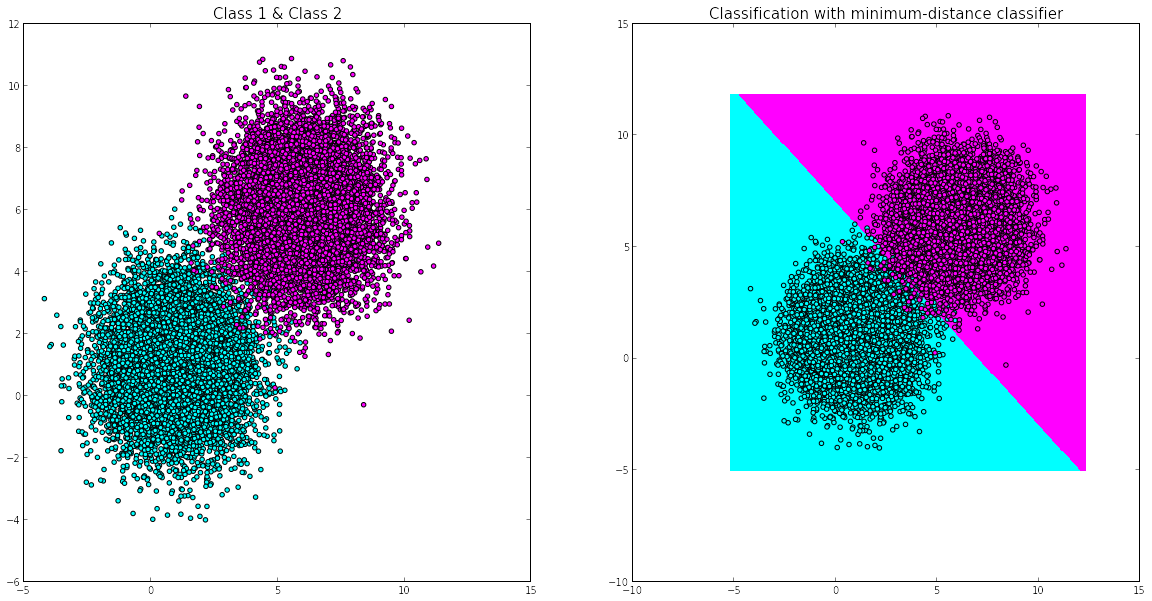

In [135]:
f, axarr = subplots(1, 2,figsize=(20,10))
axarr[0].set_title("Class 1 & Class 2", fontsize=15)
axarr[0].scatter(case1_sample_set[:,0], case1_sample_set[:,1], c=labels, cmap='cool')

axarr[1].set_title("Classification with minimum-distance classifier", fontsize=15)
visualize(classifier1, case1_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.021969

Bhattacharyya bound: 
k(0.5) = 3.124997
P(error) <= 0.021969


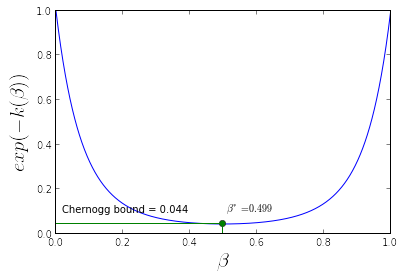

In [137]:
# distribution 
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
apriori1 = 0.5
apriori2 = 0.5
var = 2.
cov = np.array([[var,0],[0,var]])

# configuration
betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value+0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value+0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))
print 
print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))


# 1. Part B 
$P(\omega_1) != P(\omega_2)$

In [138]:
# make classifier
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
apriori1 = 0.2
apriori2 = 0.8
var = 2.
cov = np.array([[var,0],[0,var]])
classifier2 = CaseIClassifier(mean1, mean2, var, apriori1, apriori2)

# calc miss classification
calcError(classifier2, case1_sample_set, labels)

# of miss classifications for class1 = 247, Pr(error) = 0.025
# of miss classifications for class2 = 9, Pr(error) = 0.001
# of miss classifications for both   = 256, Pr(error) = 0.013


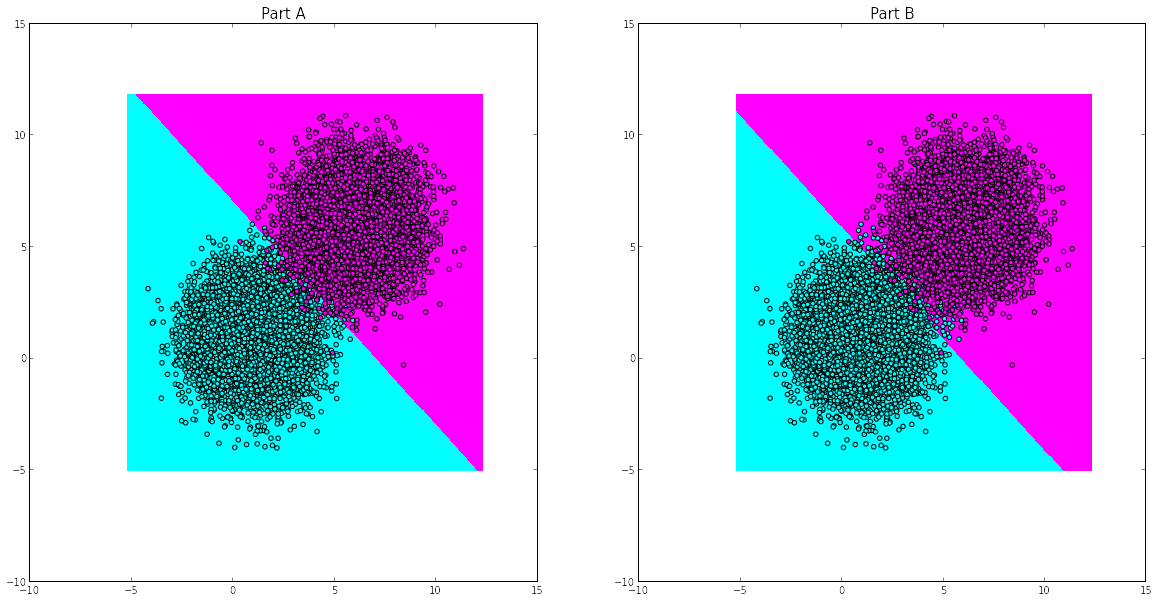

In [139]:
f, axarr = subplots(1, 2,figsize=(20,10))
axarr[0].set_title("Part A", fontsize=15)
visualize(classifier1, case1_sample_set, labels, axarr[0])

axarr[1].set_title("Part B", fontsize=15)
visualize(classifier2, case1_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.017587

Bhattacharyya bound: 
k(0.5) = 3.124997
P(error) <= 0.017575


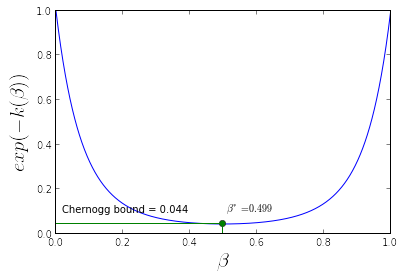

In [141]:
# distribution
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
apriori1 = 0.2
apriori2 = 0.8
var = 2.
cov = np.array([[var,0],[0,var]])

# configuration
betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value+0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value+0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))
print
print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 2. Part A

In [142]:
# make classifier 
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
cov1 = np.array([[2.,0],[0,2.]])
cov2 = np.array([[4.,0],[0,8.]])
apriori1 = 0.5
apriori2 = 0.5

classifier1 = QuadraticDiscriminant(mean1, mean2, cov1, cov2, apriori1, apriori2)

# calc miss classification
calcError(classifier1, case2_sample_set, labels)

# of miss classifications for class1 = 857, Pr(error) = 0.086
# of miss classifications for class2 = 149, Pr(error) = 0.015
# of miss classifications for both   = 1006, Pr(error) = 0.050


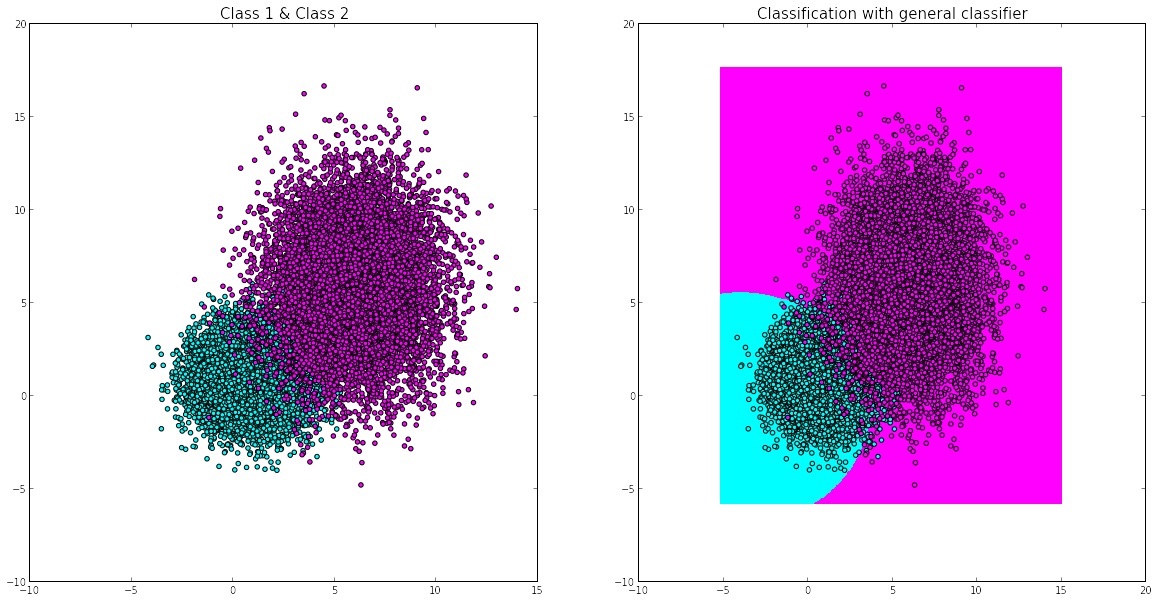

In [143]:
# plot
f, axarr = subplots(1, 2,figsize=(20, 10))
axarr[0].set_title("Class 1 & Class 2", fontsize=15)
axarr[0].scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')

axarr[1].set_title("Classification with general classifier", fontsize=15)
visualize(classifier1, case2_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.074662
Bhattacharyya bound: 
k(0.5) = 1.807684
P(error) <= 0.082017


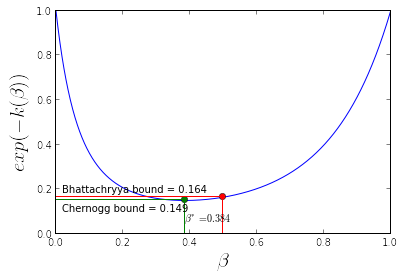

In [144]:
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
cov1 = np.array([[2.,0],[0,2.]])
cov2 = np.array([[4.,0],[0,8.]])
apriori1 = 0.5
apriori2 = 0.5

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta, ekb_value-0.1, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 2. Part B

In [145]:
# classification
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
cov1 = np.array([[2.,0],[0,2.]])
cov2 = np.array([[4.,0],[0,8.]])
apriori1 = 0.2
apriori2 = 0.8

classifier2 = QuadraticDiscriminant(mean1, mean2, cov1, cov2, apriori1, apriori2)

# calc miss classification
calcError(classifier2, case2_sample_set, labels)

# of miss classifications for class1 = 2002, Pr(error) = 0.200
# of miss classifications for class2 = 47, Pr(error) = 0.005
# of miss classifications for both   = 2049, Pr(error) = 0.102


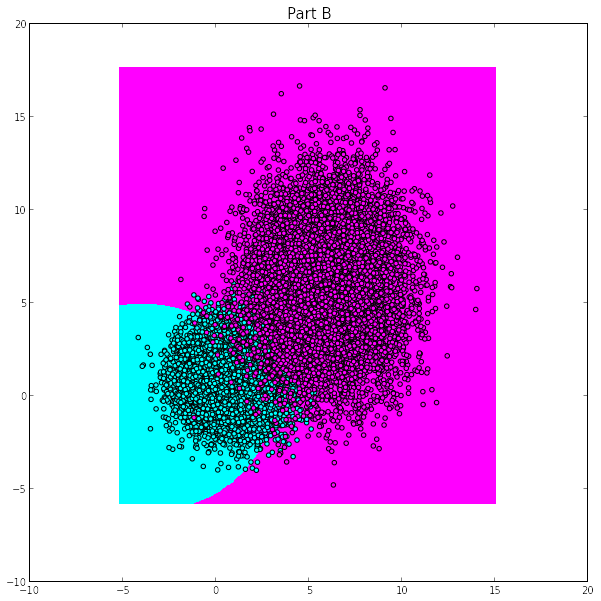

In [146]:
# plot
f, axarr = subplots(figsize=(10,10))
axarr.set_title("Part B", fontsize=15)
axarr.scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')
visualize(classifier2, case2_sample_set, labels, axarr)

Chernoff bound:
P(error) <= 0.070113
Bhattacharyya bound: 
k(0.5) = 1.807684
P(error) <= 0.065613


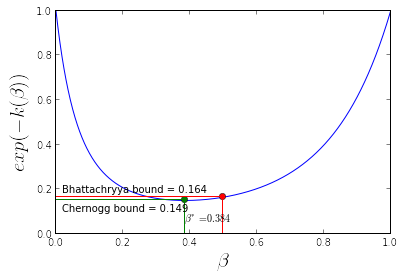

In [147]:
mean1 = np.array([1.,1.])
mean2 = np.array([6.,6.])
cov1 = np.array([[2.,0],[0,2.]])
cov2 = np.array([[4.,0],[0,8.]])
apriori1 = 0.2
apriori2 = 0.8

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta, ekb_value-0.1, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov1, cov2)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 3.

# of miss classifications for class1 = 650, Pr(error) = 0.065
# of miss classifications for class2 = 242, Pr(error) = 0.024
# of miss classifications for both   = 892, Pr(error) = 0.045


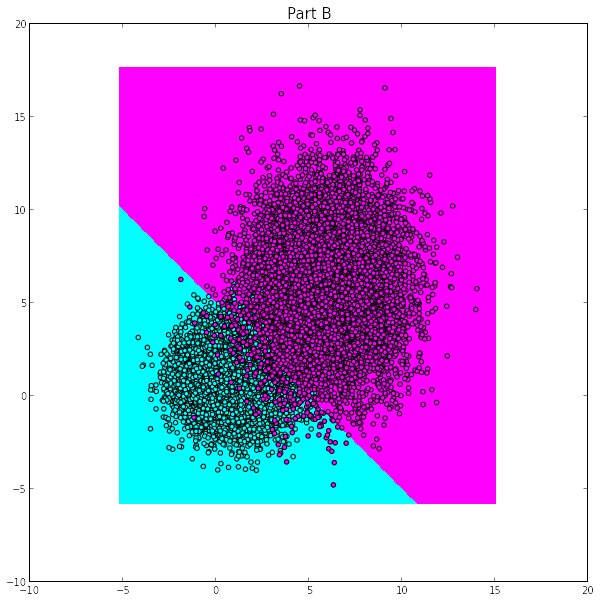

In [133]:
minClassifier = MinDistClassifier(mean1, mean2)

# calc miss classification
calcError(minClassifier, case2_sample_set, labels)

# plot
f, axarr = subplots(figsize=(10,10))
axarr.set_title("Part B", fontsize=15)
axarr.scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')
visualize(minClassifier, case2_sample_set, labels, axarr)